In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


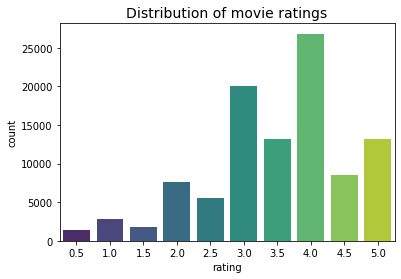

In [ ]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [ ]:
# merging datasets based on movie ID
movie_ratings = ratings.merge(movies, on='movieId')

# Printing the number of ratings given to the first 10 movies in the dataset
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

Forrest Gump, Shawshank Redemption, and Pulp Fiction have the most ratings.

In [ ]:
# printing the average rating given to each movie
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
mean_ratings

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


In [ ]:
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [ ]:
# checking no. of ratings given for the highest rated movie
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Thus, we can see that Lamerica is the highest rated movie but has got just 2 ratings. Thus we instead take a bayesian avergae to estimate true average rating of a movie

## Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where...

$C$ = confidence (average number of ratings for a given movie)

$m$ = prior (average mean rating across all movies)

$N$ = total number of reviews for movie $i$

In [ ]:
# calculating no. of ratings for each movie and corresponding average rating
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [ ]:
# defining parametrs and equation of bayesian average function

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [ ]:
# computing the bayesian avg rating for Lamerica
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

In [ ]:
# calculating the same for all movies
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [ ]:
# arranging movies in increasing order of average rating
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


### Movie Genres

In [ ]:
# converting the list of genres into an array
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
# to find the no. of unique genres
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genre_frequency)} genres.")
genre_frequency

There are 20 genres.


Counter({'(no genres listed)': 34,
         'Action': 1828,
         'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Crime': 1199,
         'Documentary': 440,
         'Drama': 4361,
         'Fantasy': 779,
         'Film-Noir': 87,
         'Horror': 978,
         'IMAX': 158,
         'Musical': 334,
         'Mystery': 573,
         'Romance': 1596,
         'Sci-Fi': 980,
         'Thriller': 1894,
         'War': 382,
         'Western': 167})

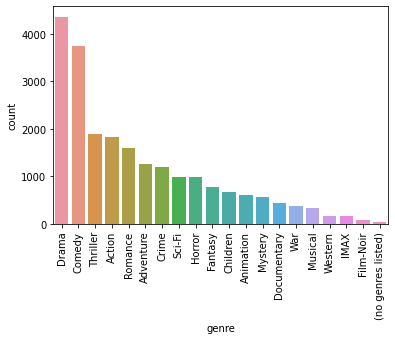

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Step 4: Data Pre-processing


In [ ]:
M = ratings['userId'].nunique()
N = ratings['movieId'].nunique()

print(M)
print(N)

610
9724


In [ ]:
user_mapper = dict(zip(np.unique(ratings["userId"]), list(range(M))))
user_mapper

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

In [ ]:
# storing the utility matrix in CSR format

from scipy.sparse import csr_matrix

def create_X(df):
 
    M = df['userId'].nunique() # no. of unique users
    N = df['movieId'].nunique() # no of unique movies

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M)))) # indexing userId's in the form of array numbering
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N)))) # indexing movieId's in the form of array numbering
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"]))) # converting indexes from array format to original
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    # obtaining CSR format of the utility matrix
    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [130]:
X

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape

(610, 9724)

`X` matrix contains 610 users and 9724 movies.

In [131]:
# total no. of elements
n_total = X.shape[0]*X.shape[1]

# calculating no. of non-zero matrix elements
n_ratings = X.nnz

sparsity = 1- (n_ratings/n_total)
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 98.3%


In [ ]:
n_ratings_per_user = X.getnnz(axis=1)
# getting non-zero values along columns
len(n_ratings_per_user)

610

In [ ]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)
# getting non-zero values along columns
len(n_ratings_per_movie)

9724

In [ ]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


## Item-item Recommendations with kNN



In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine', alg='auto'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: utility matrix
        k: number of similar movies to recommend
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T 
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id] # elements of movie_mapper refer to their array index
    movie_vec = X[movie_ind] 
    if isinstance(movie_vec, (np.ndarray)): # if movie_vec is an n-D array, reshape it to have just 1 row and as many cols as req
        movie_vec = movie_vec.reshape(1,-1)
  
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm=alg, metric=metric) # algorithms avbl - auto, brute, kd_tree, ball_tree
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n]) # append similar movieId's to a new list
    neighbour_ids.pop(0) # remove first item in list because its the reference movie itself
    return neighbour_ids

In [ ]:
# finding similar movies to movie 1
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='cosine')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='euclidean')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


In [ ]:
movie_id = 2

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='cosine')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Jumanji (1995):
Lion King, The (1994)
Mrs. Doubtfire (1993)
Mask, The (1994)
Jurassic Park (1993)
Home Alone (1990)
Nightmare Before Christmas, The (1993)
Aladdin (1992)
Beauty and the Beast (1991)
Ace Ventura: When Nature Calls (1995)


In [ ]:
movie_id = 2

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='euclidean')
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Jumanji (1995):
Casper (1995)
Ace Ventura: When Nature Calls (1995)
Flintstones, The (1994)
Honey, I Shrunk the Kids (1989)
Congo (1995)
Santa Clause, The (1994)
Home Alone 2: Lost in New York (1992)
Quick and the Dead, The (1995)
Home Alone (1990)


##Cold-start problem

In [ ]:
# making a table that represents genres present in each movie
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [ ]:
movie_genres.head()

,Film-Noir,Romance,Children,Horror,Fantasy,Crime,Drama,Mystery,War,Thriller,(no genres listed),Adventure,Comedy,Documentary,IMAX,Animation,Musical,Western,Action,Sci-Fi
0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [137]:
movie_genres.drop(columns = ['(no genres listed)'])

,Film-Noir,Romance,Children,Horror,Fantasy,Crime,Drama,Mystery,War,Thriller,Adventure,Comedy,Documentary,IMAX,Animation,Musical,Western,Action,Sci-Fi
0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0
9738,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
9739,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [138]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of genres cosine similarity matrix: (9742, 9742)


In [139]:
cosine_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

In [140]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
import fuzzywuzzy
# uses Levenshtein distance to calculate similarities between items (in this case ... the search results)

In [142]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [144]:
title = movie_finder('tyo stora')
title

'Toy Story (1995)'

In [145]:
title = movie_finder('jominji')
title

'Jumanji (1995)'

To get relevant recommendations for `Jumanji`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices:

In [146]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
movie_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Othello (1995)': 25,
 'Now and Then (1995)': 26,
 'Persuasion (1995)': 27,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29,
 'Dangerous Minds (1995)': 30,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 

In [ ]:
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using the movie_idx dictionary, we know that Jumanji is represented by index 1 in our matrix. We now get the top 10 most similar movies to Jumanji.

In [ ]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

In [ ]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

In [134]:
sim_scores = list(enumerate(cosine_sim[0]))
sim_scores

[(0, 0.9999999999999999),
 (1, 0.7745966692414835),
 (2, 0.3162277660168379),
 (3, 0.25819888974716115),
 (4, 0.4472135954999579),
 (5, 0.0),
 (6, 0.3162277660168379),
 (7, 0.6324555320336758),
 (8, 0.0),
 (9, 0.25819888974716115),
 (10, 0.25819888974716115),
 (11, 0.3162277660168379),
 (12, 0.7745966692414835),
 (13, 0.0),
 (14, 0.25819888974716115),
 (15, 0.0),
 (16, 0.0),
 (17, 0.4472135954999579),
 (18, 0.4472135954999579),
 (19, 0.19999999999999998),
 (20, 0.25819888974716115),
 (21, 0.0),
 (22, 0.0),
 (23, 0.0),
 (24, 0.0),
 (25, 0.0),
 (26, 0.3162277660168379),
 (27, 0.0),
 (28, 0.39999999999999997),
 (29, 0.0),
 (30, 0.0),
 (31, 0.0),
 (32, 0.3162277660168379),
 (33, 0.0),
 (34, 0.6324555320336758),
 (35, 0.3162277660168379),
 (36, 0.0),
 (37, 0.0),
 (38, 0.0),
 (39, 0.0),
 (40, 0.5163977794943223),
 (41, 0.25819888974716115),
 (42, 0.0),
 (43, 0.0),
 (44, 0.39999999999999997),
 (45, 0.0),
 (46, 0.0),
 (47, 0.25819888974716115),
 (48, 0.3162277660168379),
 (49, 0.63245553203367

These recommendations seem pretty relevant and similar to Jumanji. The first 5 movies are family-friendly films from the 90s.

In [147]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [148]:
get_content_based_recommendations('interstellar', 10)

Because you watched Interstellar (2014):
6996               Monsters vs. Aliens (2009)
7687                         Contagion (2011)
8013                       Cloud Atlas (2012)
8252                           Gravity (2013)
8406          The Amazing Spider-Man 2 (2014)
8414                     Transcendence (2014)
8438                  Edge of Tomorrow (2014)
1719    2010: The Year We Make Contact (1984)
1902                            Meteor (1979)
2000          It Came from Outer Space (1953)
Name: title, dtype: object


In [149]:
get_content_based_recommendations('frozen', 10)

Because you watched Frozen River (2008):
25                       Othello (1995)
30               Dangerous Minds (1995)
36      Cry, the Beloved Country (1995)
39                   Restoration (1995)
50                       Georgia (1995)
51         Home for the Holidays (1995)
55            Mr. Holland's Opus (1995)
105     Boys of St. Vincent, The (1992)
120      Basketball Diaries, The (1995)
121    Awfully Big Adventure, An (1995)
Name: title, dtype: object


In [150]:
get_content_based_recommendations('prestige', 10)

Because you watched Prestige, The (2006):
3562                                  Donnie Darko (2001)
5333                                Forgotten, The (2004)
5699                                   Jacket, The (2005)
6331                                 Prestige, The (2006)
6802               X-Files: I Want to Believe, The (2008)
7014                                          Moon (2009)
8502                                     Coherence (2013)
563     Alphaville (Alphaville, une étrange aventure d...
5729                             Scanner Darkly, A (2006)
5750                                   White Noise (2005)
Name: title, dtype: object
